In [ ]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# Object masks from prompts with SAM - SAM ile istemlerden nesne maskeleri

Segment Anything Model (SAM), istenen nesneyi belirten istemler verildiğinde nesne maskelerini tahmin eder. Model önce görüntüyü, bir istemden yüksek kaliteli maskelerin verimli bir şekilde üretilmesine olanak tanıyan bir görüntü yerleştirmeye dönüştürür.

SamPredictor sınıfı, modele istemde bulunmak için modele kolay bir arayüz sağlar. Kullanıcının önce set_image yöntemini kullanarak bir görüntü ayarlamasına olanak tanır; bu yöntem, gerekli görüntü yerleştirmelerini hesaplar. Daha sonra, bu istemlerden maskeleri verimli bir şekilde tahmin etmek için predict yöntemi aracılığıyla istemler sağlanabilir. Model, hem nokta hem de kutu istemlerini ve ayrıca önceki tahmin yinelemesinden maskeleri girdi olarak alabilir.

## Set-up

In [ ]:
import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
import sys
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

!mkdir images
!wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg
!wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/groceries.jpg
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.3.1+cu121
Torchvision version: 0.18.1+cu121
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-xg1xfr62
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-xg1xfr62
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36590 sha256=e5e73156809e53c6831a7d678096db52039d3b65510da9d4aa545628de7589b2
  Stored in directory: /tmp/pip-ephem-wheel-cache-qhotv088/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment_anything
--2024-08-13 22:25:42--  https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.c

## Gerekli kütüphane ve fonksiyonların yüklenmesi

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

### Bir görüntü üzerinde maskeleri, noktaları ve dikdörtgenleri (kutu) gösterme

### 1. **`show_mask` Fonksiyonu**


- **Parametreler:**
  - `mask`: Görüntüdeki bir nesnenin maske verilerini içeren bir NumPy dizisi. Genellikle 2D (yükseklik, genişlik) şeklindedir.
  - `ax`: matplotlib ekseni (`Axes`) nesnesi. Maskenin bu eksende gösterilmesini sağlar.
  - `random_color`: Eğer `True` ise, maskeye rastgele bir renk atanır. Eğer `False` ise, önceden belirlenmiş bir renk kullanılır.

- **Fonksiyonun İşleyişi:**
  - **Renk Seçimi:** Eğer `random_color` `True` ise, rastgele bir RGB renk ve alfa (şeffaflık) değeri oluşturulur. Aksi takdirde, sabit bir renk (`[30/255, 144/255, 255/255, 0.6]`, bu mavi bir renk tonu) seçilir.
  - **Maskenin Şekli:** Maskenin yüksekliği (`h`) ve genişliği (`w`) belirlenir.
  - **Maskeyi Görselleştirme:** Maskeyi renkli bir görüntüye dönüştürmek için, `mask` verisi ve `color` verisi birleştirilir ve `ax.imshow()` ile eksende gösterilir.

### 2. **`show_points` Fonksiyonu**


- **Parametreler:**
  - `coords`: Noktaların koordinatlarını içeren bir NumPy dizisi. Her nokta iki koordinat (x, y) içerir.
  - `labels`: Her noktanın etiketini içeren bir NumPy dizisi. Örneğin, `1` ve `0` gibi etiketler.
  - `ax`: matplotlib ekseni (`Axes`) nesnesi. Noktaların bu eksende gösterilmesini sağlar.
  - `marker_size`: Noktaların boyutu.

- **Fonksiyonun İşleyişi:**
  - **Pozitif ve Negatif Noktalar:** `coords` ve `labels` kullanılarak, pozitif (`labels==1`) ve negatif (`labels==0`) noktalar ayrılır.
  - **Noktaları Görselleştirme:** Pozitif noktalar yeşil renkte, negatif noktalar ise kırmızı renkte yıldız (`*`) işareti olarak gösterilir. `edgecolor` ve `linewidth` parametreleri, nokta sınırlarının beyaz ve 1.25 piksel kalınlığında olmasını sağlar.

### 3. **`show_box` Fonksiyonu**


- **Parametreler:**
  - `box`: Bir dikdörtgenin koordinatlarını ve boyutlarını içeren bir liste veya dizi `[x0, y0, x1, y1]`. `x0` ve `y0` sol üst köşenin koordinatları, `x1` ve `y1` ise sağ alt köşenin koordinatlarıdır.
  - `ax`: matplotlib ekseni (`Axes`) nesnesi. Dikdörtgenin bu eksende gösterilmesini sağlar.

- **Fonksiyonun İşleyişi:**
  - **Dikdörtgenin Koordinatları ve Boyutları:** Dikdörtgenin sol üst köşesi (`x0`, `y0`) ve genişliği (`w`), yüksekliği (`h`) hesaplanır.
  - **Dikdörtgeni Görselleştirme:** `plt.Rectangle` ile dikdörtgen eklenir. Dikdörtgenin kenar rengi yeşil (`edgecolor='green'`), iç rengi ise tamamen şeffaf (`facecolor=(0,0,0,0)`) olarak ayarlanır. Kenar kalınlığı (`lw`) 2 piksel olarak belirlenir.

In [ ]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))


## Örnek görselleştirme

In [ ]:
image = cv2.imread('images/truck.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

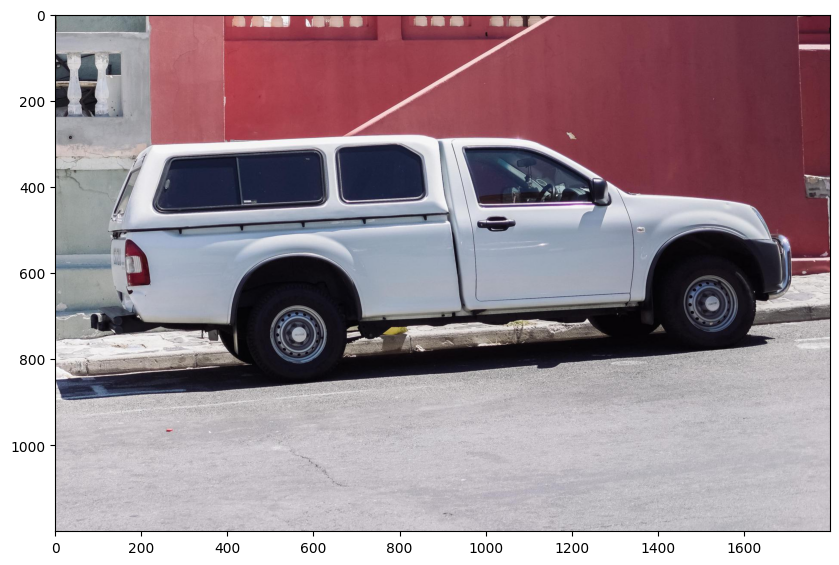

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

## SAM ile nesne seçimi

### **Modül ve Sınıfları İçe Aktarmak**

```python
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
```
- Bu satır, `segment_anything` adlı modülden gerekli sınıfları içe aktarır:
  - `sam_model_registry`: SAM modelinin kayıtlı türlerinin bulunduğu bir sözlük veya liste.
  - `SamAutomaticMaskGenerator`: Otomatik maskeleme işlemini gerçekleştiren sınıf.
  - `SamPredictor`: SAM modelinin tahmin yapabilen bir sınıf

### 3. **Model ve Aygıt Ayarları**

```python
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = "cuda"
```
- `sam_checkpoint`: Eğitimli SAM modelinin ağırlık dosyasının adı.
- `model_type`: Kullanılacak modelin türü. Bu örnekte `vit_h` (Vision Transformer, büyük boyutlu).
- `device`: Modelin çalışacağı cihaz. `cuda` ifadesi, GPU (CUDA uyumlu) kullanmak anlamına gelir.

### 4. **Modeli Yükleme ve Aygıta Gönderme**

```python
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
```
- `sam_model_registry[model_type]`: Model türüne göre (`vit_h` burada) modelin sınıfını seçer ve oluşturur. `checkpoint` parametresi, modelin önceden eğitilmiş ağırlıklarını yükler.
- `sam.to(device=device)`: Modeli belirtilen cihaz (`cuda`) üzerine taşır. Bu, modelin GPU üzerinde çalışmasını sağlar.

### 4. **`SamPredictor` Sınıfı**

```python
predictor = SamPredictor(sam)
```

Bu kod satırı, `SamPredictor` sınıfının bir örneğini oluşturur ve bu örneği `predictor` olarak adlandırır. Bu sınıf, SAM (Segment Anything Model) modelini kullanarak tahminler yapma yeteneğine sahiptir.


   - `SamPredictor`, genellikle SAM modelinin tahmin yapabilen bir sınıfıdır. Bu sınıf, modelin görüntüler üzerinde segmentasyon veya diğer tahminler yapmasını sağlar.
   - `SamPredictor` sınıfının, tahmin yapabilmek için modelin bir örneğini (`sam`) alması gerekmektedir.



In [ ]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

In [ ]:
predictor.set_image(image)

- Kamyonu seçmek için üzerinde bir nokta seçin.
- Noktalar modele (x,y) formatında girilir ve 1 (ön plan noktası) veya 0 (arka plan noktası) etiketleriyle gelir.
- Birden fazla nokta girilebilir; burada yalnızca birini kullanıyoruz.
- Seçilen nokta görüntüde bir yıldız olarak gösterilecektir.

In [ ]:
input_point = np.array([[500, 375]])
input_label = np.array([1])

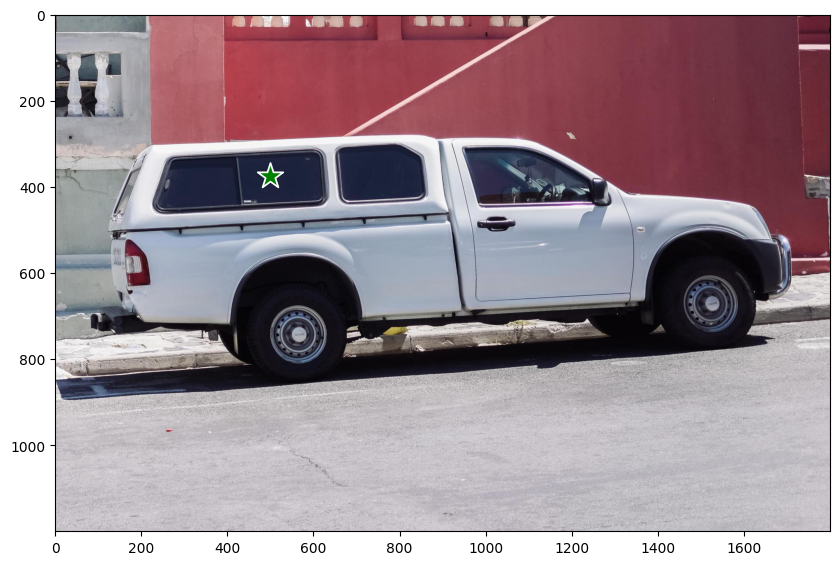

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()

`predictor` nesnesini kullanarak bir görüntü üzerinde tahminler yapar ve bu tahminlerin sonuçlarını alır. `predictor.predict()` fonksiyonu, verilen noktalara ve etiketlere dayanarak segmentasyon maskeleri üretir.



#### Parametreler:

1. **`point_coords=input_point`**
   - Bu parametre, tahmin yapılacak noktalardan oluşan koordinatları içerir. `input_point`, bir dizi (veya liste) halinde (x, y) koordinatlarını barındırır ve bu noktalar segmentasyon maskelerinin oluşturulmasında kullanılacaktır.

2. **`point_labels=input_label`**
   - Bu parametre, her noktanın etiketini belirtir. `input_label`, `input_point` koordinatlarına karşılık gelen etiketler içerir.

3. **`multimask_output=True`**
   - **Açıklama:** Bu parametre, birden fazla maske üretimini etkinleştirir.

#### Dönen Değerler:

1. **`masks`**
   - Model tarafından üretilen segmentasyon maskeleridir.

2. **`scores`**
   - Her segmentasyon maskesinin güven skorlarını içerir.

3. **`logits`**
   - Modelin tahmin ettiği ham çıktılardır. Genellikle, sınıflandırma veya segmentasyon problemlerinde, modelin her piksel için tahmin ettiği olasılıkları veya skorlardır.



In [ ]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

In [ ]:
masks.shape  # (number_of_masks) x H x W

(3, 1200, 1800)

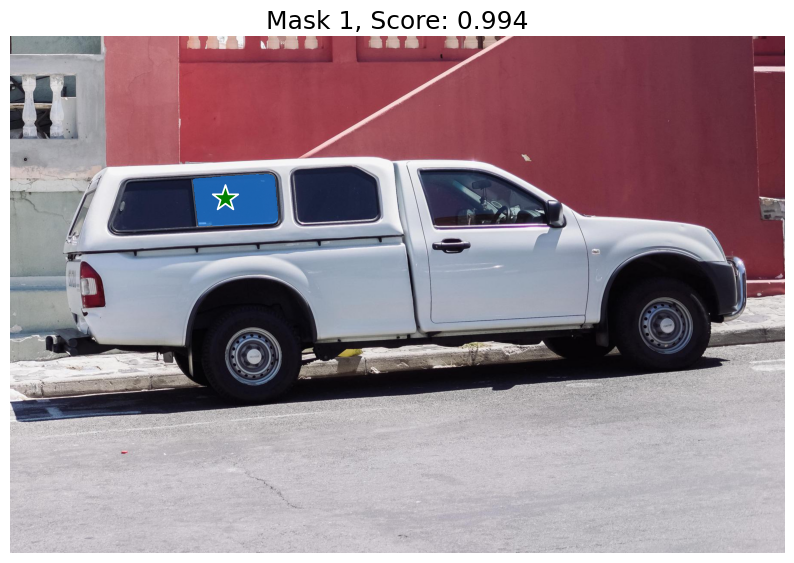

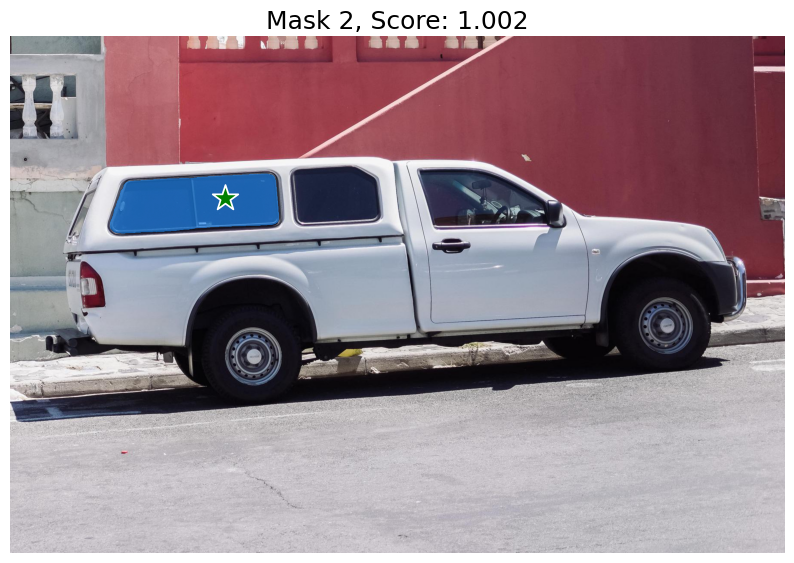

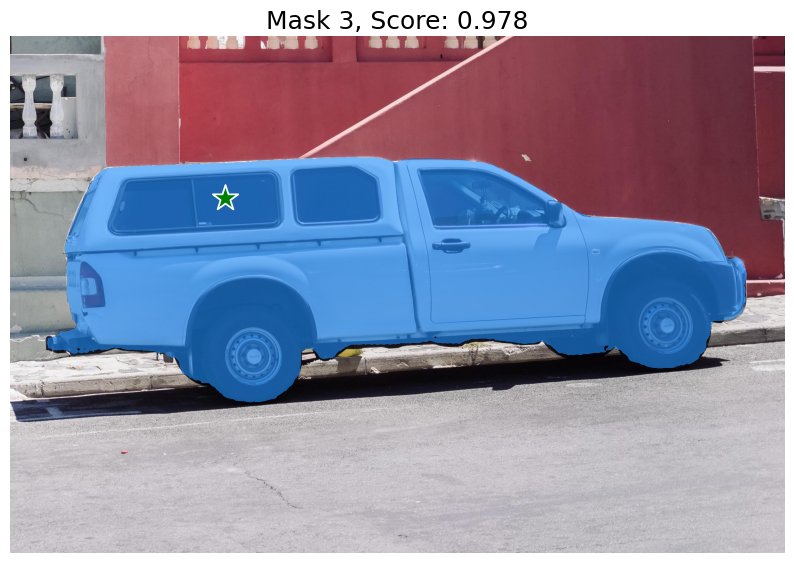

In [ ]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()


## Ek noktalarla belirli bir nesneyi tanımlama

Tek girdi noktası belirsizdir ve model bununla tutarlı birden fazla nesne döndürmüştür. Tek bir nesne elde etmek için birden fazla nokta sağlanabilir. Mevcutsa, tahminde yardımcı olması için önceki bir yinelemeden bir maske de modele sağlanabilir. Birden fazla istem içeren tek bir nesne belirtirken, multimask_output=False ayarlanarak tek bir maske talep edilebilir.

### Birden fazla nokta tanımlama

In [ ]:
input_point = np.array([[500, 375], [1125, 625]])
input_label = np.array([1, 1])

mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask

In [ ]:
masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)

In [ ]:
masks.shape

(1, 1200, 1800)

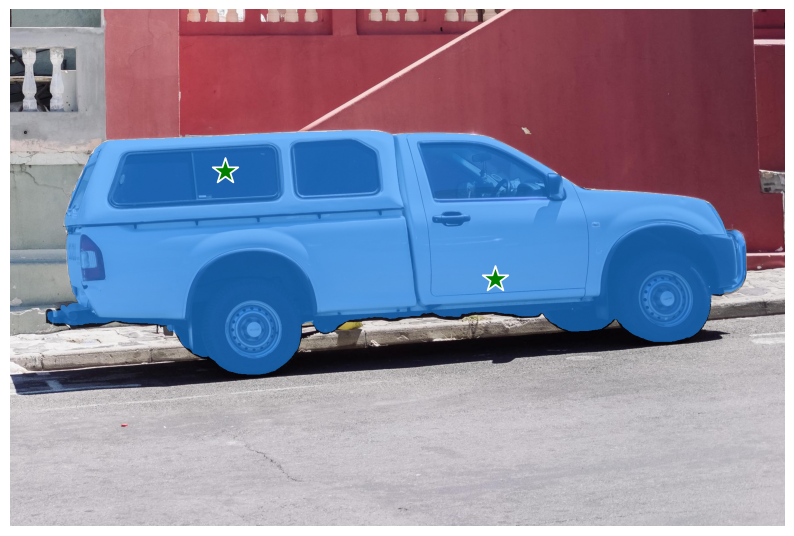

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()

### Arabayı hariç tutmak ve sadece pencereyi belirtmek için, bir arka plan noktası (burada kırmızıyla gösterilen 0 etiketli) sağlanabilir.

In [ ]:
input_point = np.array([[500, 375], [1125, 625]])
input_label = np.array([1, 0])

mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask

In [ ]:
masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)

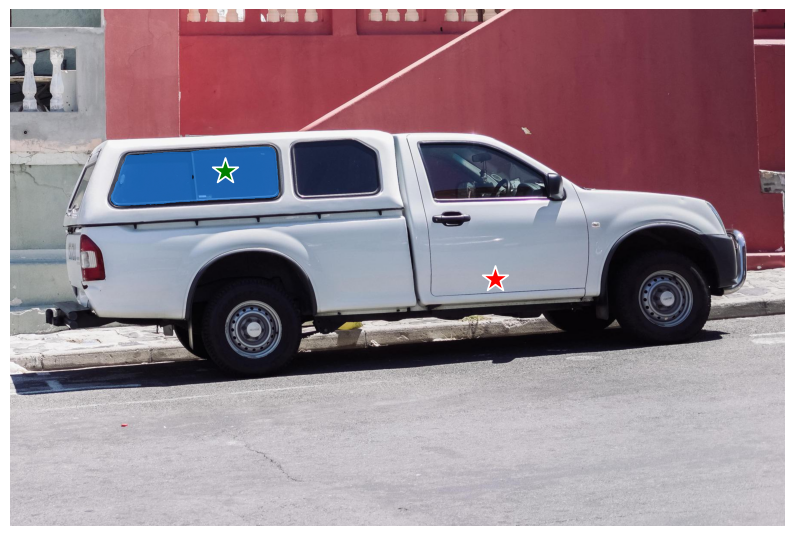

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()

## Belirli bir nesneyi kutuyla belirtme

In [ ]:
input_box = np.array([425, 600, 700, 875])

Bu kod satırı, `predictor` nesnesinin `predict()` metodunu kullanarak bir görüntü üzerinde segmentasyon maskeleri tahmin eder. Ancak, bu sefer sadece bir dikdörtgen (kutu) kullanılarak tahmin yapılır.



#### Parametreler:

1. **`point_coords=None`**
   - Bu parametre, tahmin yapılacak noktaların koordinatlarını belirtir. `None` değeri verildiğinde, nokta tabanlı tahmin yapılmaz.

2. **`point_labels=None`**
   - Bu parametre, her nokta için etiketleri belirtir. `None` değeri verildiğinde, etiket tabanlı tahmin yapılmaz.

3. **`box=input_box[None, :]`**
   - Bu parametre, tahmin yapılacak dikdörtgen kutunun koordinatlarını belirtir. `input_box` bir dikdörtgenin koordinatlarını içerir ve `None` ile bir eksen boyutu eklenmiştir. Bu şekilde, kutu şekli doğru şekilde işlenir.

4. **`multimask_output=False`**
   - Bu parametre, birden fazla maske üretimini devre dışı bırakır. `False` değeri verildiğinde, model yalnızca bir tane maske üretir. Eğer `True` olsaydı, model birden fazla olası maske üretirdi.

#### Dönen Değerler:

1. **`masks`**
   - Model tarafından üretilen segmentasyon maskeleridir.

2. **`_` (ilk boş değer)**
   - Bu değer, modelin tahmin ettiği skorları veya diğer bilgi türlerini temsil eder.

3. **`_` (ikinci boş değer)**
   - Bu değer, modelin tahmin ettiği logitleri veya diğer bilgi türlerini temsil eder.


In [ ]:
masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

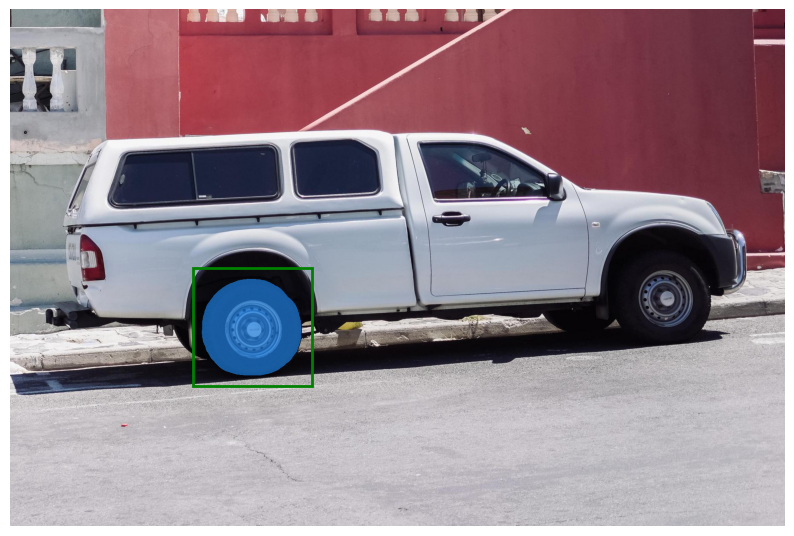

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
plt.axis('off')
plt.show()

## Noktaları ve kutuları birleştirme

In [ ]:
input_box = np.array([425, 600, 700, 875])
input_point = np.array([[575, 750]])
input_label = np.array([0])

In [ ]:
masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    box=input_box,
    multimask_output=False,
)

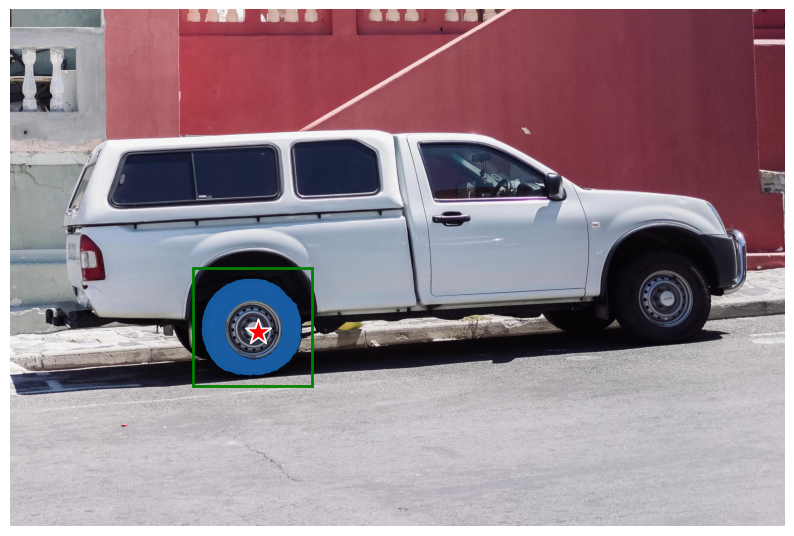

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()

## Toplu istem girdileri (Batched prompt inputs)

- SamPredictor, predict_torch metodunu kullanarak aynı görüntü için birden fazla giriş istemi alabilir.
- Bu metot, giriş noktalarının zaten torch tensörleri olduğunu ve giriş karesine dönüştürüldüğünü varsayar.

In [ ]:
input_boxes = torch.tensor([
    [75, 275, 1725, 850],
    [425, 600, 700, 875],
    [1375, 550, 1650, 800],
    [1240, 675, 1400, 750],
], device=predictor.device)

1. **`transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, image.shape[:2])`**

   - **`predictor.transform.apply_boxes_torch`**:
     -  Bu, `predictor` nesnesinin bir dönüştürme (transform) işlevi olup, kutu koordinatlarını (box coordinates) modelin giriş formatına dönüştürür.
     - **Fonksiyon:** `apply_boxes_torch` genellikle kutu koordinatlarını PyTorch tensor formatına dönüştürür ve modelin beklentilerine uygun hale getirir.

   - **`input_boxes`**:
     - Tahmin yapılacak kutuların koordinatlarını içeren bir liste veya dizi olup genellikle `[x0, y0, x1, y1]` formatında olur.
   
   - **`image.shape[:2]`**:
     - Görüntünün yüksekliği ve genişliği.

   - **Sonuç:** `transformed_boxes`, modelin tahmin yapması için uygun formatta dönüştürülmüş kutu koordinatlarını içerir.

2. **`masks, _, _ = predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=transformed_boxes,
    multimask_output=False,
)`**

   - **`predictor.predict_torch`**:
     - `predictor` nesnesinin PyTorch tabanlı tahmin metodudur. Bu metod, dönüştürülmüş kutular üzerinde tahmin yapar.

   - **Parametreler:**
     - **`point_coords=None`**: Nokta tabanlı tahmin yapılmaz.
     - **`point_labels=None`**: Etiket tabanlı tahmin yapılmaz.
     - **`boxes=transformed_boxes`**: Daha önce dönüştürülmüş kutu koordinatları kullanılır.
     - **`multimask_output=False`**: Yalnızca bir maske üretilecektir. Birden fazla maske üretmek için `True` değeri verilmelidir.

   - **Dönen Değerler:**
     - **`masks`**: Model tarafından üretilen segmentasyon maskeleridir. `transformed_boxes` üzerinde tahmin edilmiştir.
     - **`_` (ilk boş değer)**: Modelin tahmin ettiği skorları veya diğer bilgi türlerini temsil eder, ancak burada kullanılmamaktadır.
     - **`_` (ikinci boş değer)**: Modelin tahmin ettiği logitleri veya diğer bilgi türlerini temsil eder, ancak burada kullanılmamaktadır.


In [ ]:
transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, image.shape[:2])
masks, _, _ = predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=transformed_boxes,
    multimask_output=False,
)

In [ ]:
masks.shape  # (batch_size) x (num_predicted_masks_per_input) x H x W

torch.Size([4, 1, 1200, 1800])

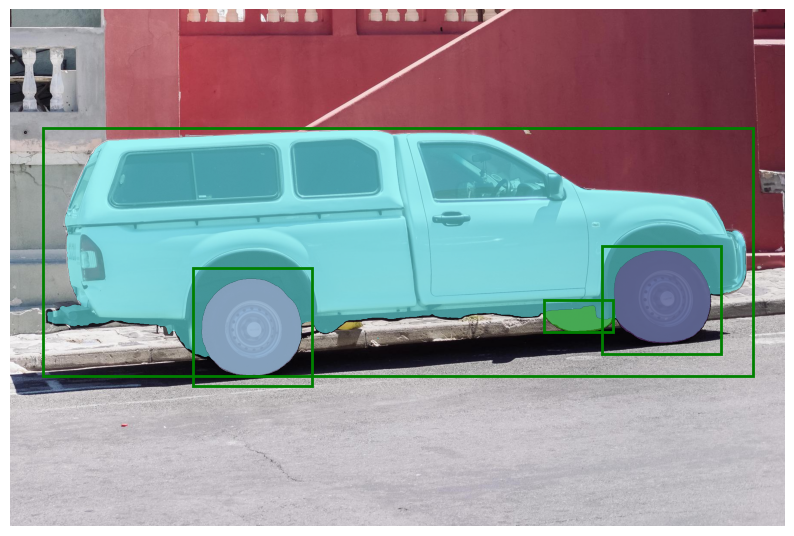

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
for mask in masks:
    show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)
for box in input_boxes:
    show_box(box.cpu().numpy(), plt.gca())
plt.axis('off')
plt.show()

## Uçtan uca toplu çıkarım

Tüm istemler önceden mevcutsa, SAM'ı doğrudan uçtan uca bir şekilde çalıştırmak mümkündür. Bu ayrıca görüntüler üzerinde toplu işlem yapılmasına da olanak tanır.

In [ ]:
image1 = image  # truck.jpg from above
image1_boxes = torch.tensor([
    [75, 275, 1725, 850],
    [425, 600, 700, 875],
    [1375, 550, 1650, 800],
    [1240, 675, 1400, 750],
], device=sam.device)

image2 = cv2.imread('images/groceries.jpg')
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
image2_boxes = torch.tensor([
    [450, 170, 520, 350],
    [350, 190, 450, 350],
    [500, 170, 580, 350],
    [580, 170, 640, 350],
], device=sam.device)

### görüntüyü modelin giriş formatına uygun hale getirme


1. **`from segment_anything.utils.transforms import ResizeLongestSide`**
   -  Bu sınıf, görüntünün en uzun kenarını belirli bir boyuta yeniden boyutlandırmak için kullanılır.

2. **`resize_transform = ResizeLongestSide(sam.image_encoder.img_size)`**
   - `ResizeLongestSide` sınıfından bir `resize_transform` nesnesi oluşturur. Bu nesne, `sam.image_encoder.img_size` boyutuna göre görüntünün en uzun kenarını yeniden boyutlandıracaktır.
   - **`sam.image_encoder.img_size`**: Bu, modelin giriş boyutunu belirler. `ResizeLongestSide` sınıfı, bu boyuta göre görüntüyü yeniden boyutlandıracaktır.

3. **`def prepare_image(image, transform, device):`**
   - Bu fonksiyon, bir görüntüyü belirtilen dönüşüm (`transform`) ve cihaz (`device`) kullanarak hazırlamak için tanımlanmıştır.

4. **`image = transform.apply_image(image)`**
   - `transform.apply_image(image)` ifadesi, `transform` nesnesini (bu durumda `ResizeLongestSide`) kullanarak görüntüyü dönüştürür. Bu, görüntünün en uzun kenarını belirtilen boyuta yeniden boyutlandırır.

5. **`image = torch.as_tensor(image, device=device.device)`**
   - `image` NumPy dizisini bir PyTorch tensoruna dönüştürür. Bu tensor, belirtilen `device` üzerinde bulunur. `device.device` ifadesi, cihazın (`device`) gerçek `device` (örneğin `cuda` veya `cpu`) nesnesini temsil eder.
   - **Önemli:** Bu işlem, tensorun modelin çalışacağı cihaza (GPU veya CPU) taşınmasını sağlar.

6. **`return image.permute(2, 0, 1).contiguous()`**
   - `permute(2, 0, 1)` ifadesi, tensorun boyutlarını değiştirir. PyTorch, görüntüleri `(H, W, C)` şeklinde (yükseklik, genişlik, kanal) saklarken, çoğu model `(C, H, W)` şeklinde (kanal, yükseklik, genişlik) giriş bekler. Bu işlem, bu boyut dönüşümünü yapar.
   - **`contiguous()`**: PyTorch tensorunun bellek düzenini düzelten bir işlemdir. Tensorun bellek düzenini, modelin daha verimli çalışması için uyumlu hale getirir.



In [ ]:
from segment_anything.utils.transforms import ResizeLongestSide
resize_transform = ResizeLongestSide(sam.image_encoder.img_size)

def prepare_image(image, transform, device):
    image = transform.apply_image(image)
    image = torch.as_tensor(image, device=device.device)
    return image.permute(2, 0, 1).contiguous()

In [ ]:
batched_input = [
     {
         'image': prepare_image(image1, resize_transform, sam),
         'boxes': resize_transform.apply_boxes_torch(image1_boxes, image1.shape[:2]),
         'original_size': image1.shape[:2]
     },
     {
         'image': prepare_image(image2, resize_transform, sam),
         'boxes': resize_transform.apply_boxes_torch(image2_boxes, image2.shape[:2]),
         'original_size': image2.shape[:2]
     }
]

In [ ]:
batched_output = sam(batched_input, multimask_output=False)

Her giriş görüntüsü için sonuçlar içeren bir liste olup, liste elemanları şu anahtarları içeren sözlüklerdir:

* `masks`: Orijinal görüntünün boyutunda, tahmin edilen ikili maskelerin topluca PyTorch tensörü.
* `iou_predictions`: Modelin her maske için kalite tahmini.
* `low_res_logits`: Her maske için düşük çözünürlüklü logitler; bu logitler, sonraki bir iterasyonda maske girişi olarak modele geri geçirilebilir.

In [ ]:
batched_output[0].keys()

dict_keys(['masks', 'iou_predictions', 'low_res_logits'])

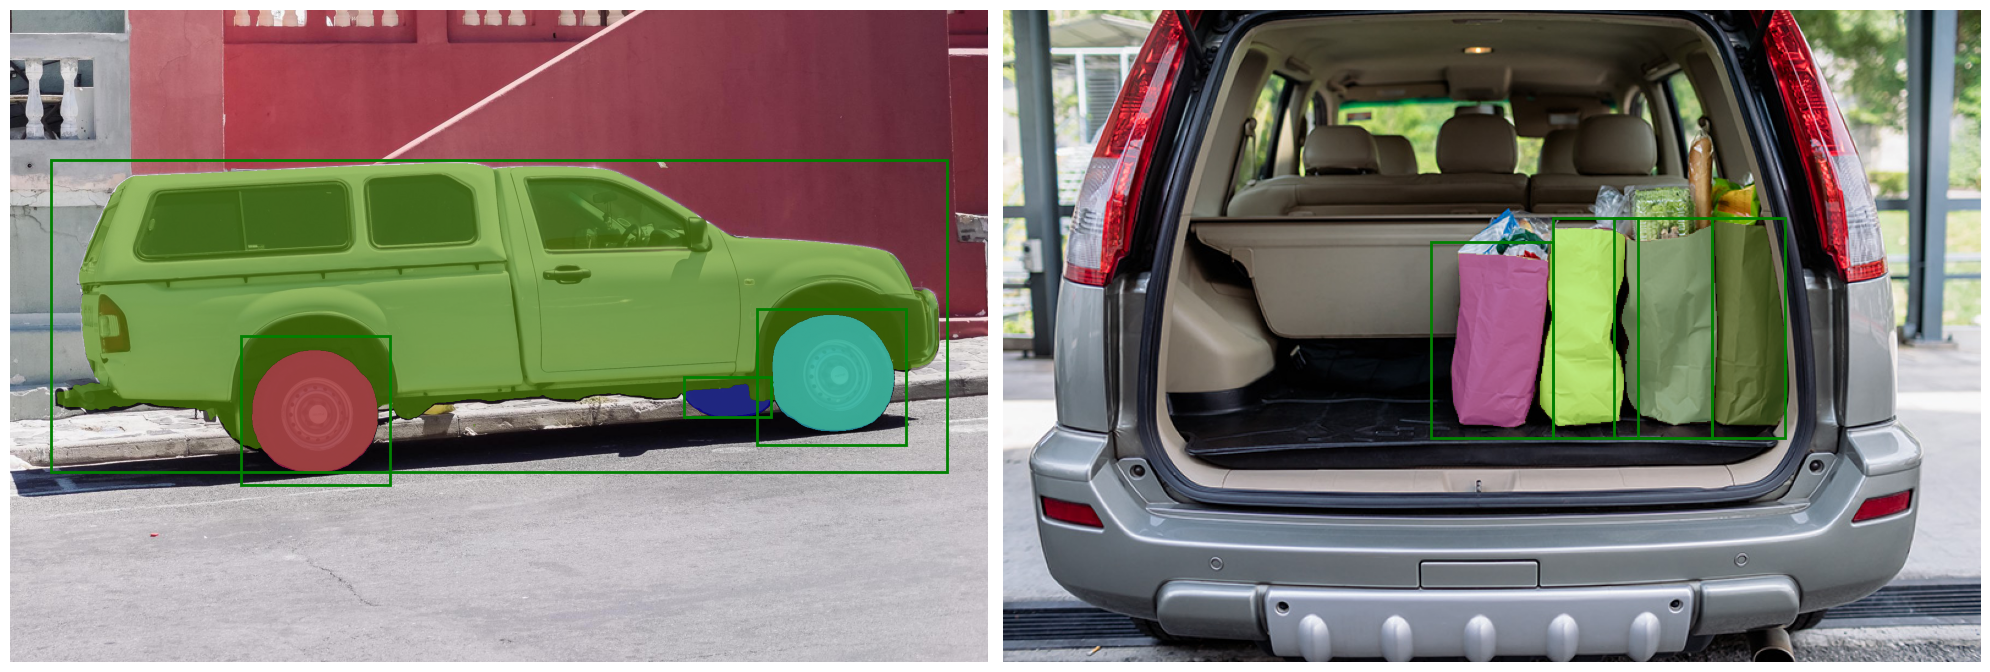

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 20))

ax[0].imshow(image1)
for mask in batched_output[0]['masks']:
    show_mask(mask.cpu().numpy(), ax[0], random_color=True)
for box in image1_boxes:
    show_box(box.cpu().numpy(), ax[0])
ax[0].axis('off')

ax[1].imshow(image2)
for mask in batched_output[1]['masks']:
    show_mask(mask.cpu().numpy(), ax[1], random_color=True)
for box in image2_boxes:
    show_box(box.cpu().numpy(), ax[1])
ax[1].axis('off')

plt.tight_layout()
plt.show()